In [28]:
#!pip install --upgrade pip
#!pip install tensorflow==2.1.0
#!pip install keras_tuner
from importlib import reload
import sys
from imp import reload
import warnings
warnings.filterwarnings('ignore')
if sys.version[0] == '2':
    reload(sys)
    sys.setdefaultencoding("utf-8")
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
import pandas as pd
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/tmp/ipykernel_541/2043581675.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [2]:
df1 = pd.read_csv('/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip', delimiter="\t")
df1 = df1.drop(['id'], axis=1)
df1.head()

sentiment                                             review
0          1  With all this stuff going down at the moment w...
1          1  \The Classic War of the Worlds\" by Timothy Hi...
2          0  The film starts with a manager (Nicholas Bell)...
3          0  It must be assumed that those who praised this...
4          1  Superbly trashy and wondrously unpretentious 8...

In [3]:
df2 = pd.read_csv('../input/imdb-review-dataset/imdb_master.csv',encoding="latin-1")
df2.head()

Unnamed: 0  type                                             review label  \
0           0  test  Once again Mr. Costner has dragged out a movie...   neg   
1           1  test  This is an example of why the majority of acti...   neg   
2           2  test  First of all I hate those moronic rappers, who...   neg   
3           3  test  Not even the Beatles could write songs everyon...   neg   
4           4  test  Brass pictures (movies is not a fitting word f...   neg   

          file  
0      0_2.txt  
1  10000_4.txt  
2  10001_1.txt  
3  10002_3.txt  
4  10003_3.txt

In [4]:
df2 = df2.drop(['Unnamed: 0','type','file'],axis=1)
df2.columns = ["review","sentiment"]
df2.head()

review sentiment
0  Once again Mr. Costner has dragged out a movie...       neg
1  This is an example of why the majority of acti...       neg
2  First of all I hate those moronic rappers, who...       neg
3  Not even the Beatles could write songs everyon...       neg
4  Brass pictures (movies is not a fitting word f...       neg

In [5]:
df2 = df2[df2.sentiment != 'unsup']
df2['sentiment'] = df2['sentiment'].map({'pos': 1, 'neg': 0})
df2.head()

review  sentiment
0  Once again Mr. Costner has dragged out a movie...          0
1  This is an example of why the majority of acti...          0
2  First of all I hate those moronic rappers, who...          0
3  Not even the Beatles could write songs everyon...          0
4  Brass pictures (movies is not a fitting word f...          0

In [6]:
df = pd.concat([df1, df2]).reset_index(drop=True)
#df = df.drop_duplicates()
df.shape
df.drop_duplicates(inplace=True)#удаляю
print(df.duplicated())#еще раз проверяю
#df.head()

0        False
1        False
2        False
3        False
4        False
         ...  
74991    False
74994    False
74995    False
74996    False
74999    False
Length: 62155, dtype: bool


In [7]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

df['Processed_Reviews'] = df.review.apply(lambda x: clean_text(x))

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [9]:
df.head()

sentiment                                             review  \
0          1  With all this stuff going down at the moment w...   
1          1  \The Classic War of the Worlds\" by Timothy Hi...   
2          0  The film starts with a manager (Nicholas Bell)...   
3          0  It must be assumed that those who praised this...   
4          1  Superbly trashy and wondrously unpretentious 8...   

                                   Processed_Reviews  
0  stuff go moment mj ive start listen music watc...  
1  classic war world timothy hines entertain film...  
2  film start manager nicholas bell give welcome ...  
3  must assume praise film greatest film opera ev...  
4  superbly trashy wondrously unpretentious 80 ex...

In [10]:
df.Processed_Reviews.apply(lambda x: len(x.split(" "))).mean()

134.23220979808542

In [ ]:

sentences=df['review']
stopwords = set(STOPWORDS) 
stopwords.add('br')
pos=' '.join(map(str,sentences[df['sentiment']==1]))
neg=' '.join(map(str,sentences[df['sentiment']==0]))
  
wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(pos) 

plt.figure(figsize=(8,8))
plt.imshow(wordcloud1)
plt.title('Positive Sentiment')
plt.axis('off')

In [ ]:
wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(neg) 

plt.figure(figsize=(8,8))
plt.imshow(wordcloud2)
plt.title('Negative Sentiment')
plt.axis('off')

In [ ]:
import seaborn as sns
sns.countplot(x=df['sentiment'])
plt.grid()

In [ ]:
import keras

keras.__version__

In [12]:
import tensorflow as tf
import keras_tuner
N_WORDS = 6000
MAX_LEN = 130
DIM_EMBEDDING = 64
EMBED_SIZE = 128

tokenizer = Tokenizer(num_words=N_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ")
tokenizer.fit_on_texts(df['Processed_Reviews'])

list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_Reviews'])

# Add bigrams to the tokenizer
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= N_WORDS}
tokenizer.word_index[tokenizer.num_words] = tokenizer.num_words
tokenizer.word_index[tokenizer.num_words + 1] = tokenizer.num_words + 1
num_words = tokenizer.num_words + 1


def pad_content_input(sentence_sequences, n_gram_range):
    return [[col for idx, col in enumerate(row) if not (col > n_gram_range + len(row) or idx - col < 1)] for row in sentence_sequences]

list_tokenized_train_with_bigrams = tokenizer.texts_to_sequences(list(df['Processed_Reviews']))
max_features = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
#max_len = max_len + 2  # for the bigrams
#max_features = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index


#max_features = 6000
#tokenizer = Tokenizer(num_words=max_features)
#tokenizer.fit_on_texts(df['Processed_Reviews'])
#list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_Reviews'])

X_t = pad_sequences(list_tokenized_train_with_bigrams, maxlen=MAX_LEN+2)
y = df['sentiment']

class SentimentAnalysisModel(Sequential):
    def __init__(self, n_classes, n_words, dim_embedding, max_len, conv_filters=64, dropout_rate=0.2, conv_act='relu', recc_act = 'relu', number_conv_layers=2, is_sep_conv=False, is_reccurent = True, is_conv = True, type_rec='gru', number_neurons_rec=64, number_dense=1):
        super(SentimentAnalysisModel, self).__init__()
        self.add(layers.Embedding(n_words, dim_embedding, input_length=max_len+2))
        if is_conv:
            for i in range(number_conv_layers):
                if not is_sep_conv:
                    self.add(layers.Conv1D(conv_filters,activation=conv_act, kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
                else: 
                    self.add(layers.Conv1D(conv_filters,activation=conv_act, kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
                conv_filters = conv_filters//2
            #self.add(layers.Conv1D(conv_filters//2,activation=conv_act, kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
        self.add(layers.BatchNormalization())
        if is_reccurent:
            self.add(keras.layers.MaxPooling1D(2))
        else:
            self.add(GlobalMaxPool1D())
        if is_reccurent:
            if type_rec=='gru':
                self.add(layers.GRU(number_neurons_rec, activation=recc_act))
            else:
                self.add(layers.LSTM(number_neurons_rec, activation=recc_act))
        self.add(layers.Dropout(dropout_rate))
        if n_classes==2:
            self.add(layers.Dense(1, activation='sigmoid'))
        else:
            self.add(layers.Flatten())
            self.add(layers.Dense(n_classes, activation='softmax'))

    def call(self, inputs):
        return super(SentimentAnalysisModel, self).call(inputs)
    
conv_filters = 64
gru_units = 64
dropout_rate = 0.2
def build_model(hp):
    dim_embedding = hp.Int("dim_embedding", min_value=64, max_value=128, step=64)
    activation = hp.Choice("activation", ["relu", "selu","gelu", "swish"])
    conv_filters = hp.Choice("conv_filters", [32,64,128])
    dropout_rate = hp.Choice("dropout_rate", [0.2])
    #dropout = hp.Boolean("dropout")
    conv_act = hp.Choice("conv_act", ["relu", "selu","gelu", "swish"])
    recc_act = hp.Choice("recc_act", ["relu", "selu","gelu", "swish"])
    is_sep_conv = hp.Boolean("is_sep_conv")
    is_reccurent = hp.Boolean("is_reccurent")
    number_conv_layers = hp.Choice("number_conv_layers", [1,2])
    is_conv = hp.Boolean("is_conv")
    number_neurons_rec = hp.Choice("conv_filters", [32,64])
    optimizer = activation = hp.Choice("optimizer", ["adam", "rmsprop"])
    model = SentimentAnalysisModel(n_classes=2, n_words=N_WORDS, dim_embedding=dim_embedding, max_len=MAX_LEN, conv_filters=conv_filters, dropout_rate = dropout_rate, conv_act=conv_act, recc_act=recc_act, is_conv = is_conv, number_neurons_rec=number_neurons_rec,is_sep_conv=is_sep_conv, is_reccurent=is_reccurent,number_conv_layers=number_conv_layers)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy",keras.metrics.F1Score(), keras.metrics.Precision(), keras.metrics.Recall()])
    return model

#model = SentimentAnalysisModel(n_classes=2, n_words=N_WORDS+1, dim_embedding=DIM_EMBEDDING, max_len=MAX_LEN+2, conv_filters=conv_filters, dropout_rate = dropout_rate, conv_act='selu', recc_act='selu')
#build_model(keras_tuner.HyperParameters())


batch_size = 100
epochs = 10
#model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)
model = Sequential()
model.add(layers.Embedding(N_WORDS, DIM_EMBEDDING, input_length=MAX_LEN+2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(2))
model.add(layers.GRU(128,activation="selu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy",keras.metrics.F1Score(), keras.metrics.Precision(), keras.metrics.Recall()])
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/10
  7/498 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.5273 - f1_score: 0.6511 - loss: 0.7762 - precision_2: 0.5181 - recall_2: 0.3730

I0000 00:00:1718121580.154080     403 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718121580.187587     403 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


498/498 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.7134 - f1_score: 0.6689 - loss: 0.5058 - precision_2: 0.7135 - recall_2: 0.7167 - val_accuracy: 0.9303 - val_f1_score: 0.6492 - val_loss: 0.2278 - val_precision_2: 0.9149 - val_recall_2: 0.9428
Epoch 2/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9312 - f1_score: 0.6669 - loss: 0.1857 - precision_2: 0.9290 - recall_2: 0.9339 - val_accuracy: 0.9733 - val_f1_score: 0.6492 - val_loss: 0.0977 - val_precision_2: 0.9722 - val_recall_2: 0.9722
Epoch 3/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9681 - f1_score: 0.6643 - loss: 0.0960 - precision_2: 0.9666 - recall_2: 0.9695 - val_accuracy: 0.9879 - val_f1_score: 0.6492 - val_loss: 0.0442 - val_precision_2: 0.9870 - val_recall_2: 0.9878
Epoch 4/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9859 - f1_score: 0.6679 - loss: 0.0453 - precision_2: 0.9850 - recall_2: 0.9869 - val_accuracy: 0.9924 - val_f1_score: 0.6492 - val_loss: 0.0255 - val_precision

In [13]:
model.save("imdb.h5")

In [27]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=60,
    executions_per_trial=1,
    overwrite=True,
    directory="my_dir",
    project_name="imdb",
)

In [28]:
tuner.search_space_summary()

Search space summary
Default search space size: 11
dim_embedding (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 64, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'selu', 'gelu', 'swish'], 'ordered': False}
conv_filters (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
dropout_rate (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2], 'ordered': True}
conv_act (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'selu', 'gelu', 'swish'], 'ordered': False}
recc_act (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'selu', 'gelu', 'swish'], 'ordered': False}
is_sep_conv (Boolean)
{'default': False, 'conditions': []}
is_reccurent (Boolean)
{'default': False, 'conditions': []}
number_conv_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2], 'ordered': True}
is_conv (Boolean)
{'default': False, 'conditions': []}
optimi

In [29]:
tuner.search(X_t,y, batch_size=100, epochs=10, validation_split=0.2)

Trial 60 Complete [00h 00m 21s]
val_accuracy: 0.9679832458496094

Best val_accuracy So Far: 0.9959778189659119
Total elapsed time: 00h 51m 36s


In [34]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=5)
best_model = models[0]
best_model.summary()
models[2].summary()
models[3].summary()

Model: "sentiment_analysis_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 132, 128)       │       768,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 132, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 66, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 867,713 (3.31 MB)

 Trainable params: 867,457 (3.31 MB)

 Non-trainable params: 256 (1.00 KB)

Model: "sentiment_analysis_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 132, 128)       │       768,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 132, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 66, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 32)             │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 784,097 (2.99 MB)

 Trainable params: 783,841 (2.99 MB)

 Non-trainable params: 256 (1.00 KB)

Model: "sentiment_analysis_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 132, 64)        │       384,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 132, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 66, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 393,697 (1.50 MB)

 Trainable params: 393,569 (1.50 MB)

 Non-trainable params: 128 (512.00 B)

In [35]:
tuner.results_summary()

Results summary
Results in my_dir/imdb
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 14 summary
Hyperparameters:
dim_embedding: 128
activation: selu
conv_filters: 128
dropout_rate: 0.2
conv_act: swish
recc_act: selu
is_sep_conv: True
is_reccurent: True
number_conv_layers: 2
is_conv: False
optimizer: adam
Score: 0.9959778189659119

Trial 53 summary
Hyperparameters:
dim_embedding: 128
activation: relu
conv_filters: 128
dropout_rate: 0.2
conv_act: selu
recc_act: swish
is_sep_conv: False
is_reccurent: True
number_conv_layers: 1
is_conv: False
optimizer: adam
Score: 0.9957364797592163

Trial 52 summary
Hyperparameters:
dim_embedding: 128
activation: relu
conv_filters: 32
dropout_rate: 0.2
conv_act: selu
recc_act: selu
is_sep_conv: False
is_reccurent: True
number_conv_layers: 1
is_conv: False
optimizer: adam
Score: 0.9954951405525208

Trial 57 summary
Hyperparameters:
dim_embedding: 64
activation: gelu
conv_filters: 32
dropout_rate: 0.2
conv_act: relu
recc_act

In [36]:
import shutil
shutil.make_archive('imdb', 'zip', '/kaggle')


OSError: [Errno 28] No space left on device

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

max_features = 6000
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ")
tokenizer.fit_on_texts(df['Processed_Reviews'])

list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_Reviews'])

# Add bigrams to the tokenizer
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= max_features}
tokenizer.word_index[tokenizer.num_words] = tokenizer.num_words
tokenizer.word_index[tokenizer.num_words + 1] = tokenizer.num_words + 1
num_words = tokenizer.num_words + 1
max_len = 130

def pad_content_input(sentence_sequences, n_gram_range):
    return [[col for idx, col in enumerate(row) if not (col > n_gram_range + len(row) or idx - col < 1)] for row in sentence_sequences]

list_tokenized_train_with_bigrams = tokenizer.texts_to_sequences(list(df['Processed_Reviews']))
max_features = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
max_len = max_len + 2  # for the bigrams

#max_features = 6000
#tokenizer = Tokenizer(num_words=max_features)
#tokenizer.fit_on_texts(df['Processed_Reviews'])
#list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_Reviews'])

maxlen = 130
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
y = df['sentiment']
num_words = 20000
max_len = 130
n_words = 10000
dim_embedding = 64
embed_size = 128
model = Sequential()
model.add(layers.Embedding(n_words, dim_embedding, input_length=max_len))
    #model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(64,activation='selu', kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
model.add(layers.Conv1D(32,activation='selu', kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
model.add(layers.Bidirectional(layers.LSTM(32,activation='relu', return_sequences=True)))
model.add(GlobalMaxPool1D())
#model.add(layers.Bidirectional(layers.GRU(32,activation='relu')))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
#model.add(Embedding(max_features, embed_size))
#model.add(Bidirectional(LSTM(32, return_sequences = True)))
#model.add(GlobalMaxPool1D())
#model.add(Dense(20, activation="relu"))
#model.add(Dropout(0.05))
#model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 100
epochs = 10
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

max_features = 6000
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ")
tokenizer.fit_on_texts(df['Processed_Reviews'])

list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_Reviews'])

# Add bigrams to the tokenizer
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= max_features}
tokenizer.word_index[tokenizer.num_words] = tokenizer.num_words
tokenizer.word_index[tokenizer.num_words + 1] = tokenizer.num_words + 1
num_words = tokenizer.num_words + 1
max_len = 130

def pad_content_input(sentence_sequences, n_gram_range):
    return [[col for idx, col in enumerate(row) if not (col > n_gram_range + len(row) or idx - col < 1)] for row in sentence_sequences]

list_tokenized_train_with_bigrams = tokenizer.texts_to_sequences(list(df['Processed_Reviews']))
max_features = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
max_len = max_len + 2  # for the bigrams

#max_features = 6000
#tokenizer = Tokenizer(num_words=max_features)
#tokenizer.fit_on_texts(df['Processed_Reviews'])
#list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_Reviews'])

maxlen = 130
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
y = df['sentiment']

max_len = 130
n_words = 10000
dim_embedding = 64
embed_size = 128
model = Sequential()
model.add(layers.Embedding(n_words, dim_embedding, input_length=max_len))
    #model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(64,activation='selu', kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
model.add(layers.Conv1D(32,activation='selu', kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
model.add(layers.Bidirectional(layers.GRU(32,activation='relu', return_sequences=True)))
model.add(GlobalMaxPool1D())
#model.add(layers.Bidirectional(layers.GRU(32,activation='relu')))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
#model.add(Embedding(max_features, embed_size))
#model.add(Bidirectional(LSTM(32, return_sequences = True)))
#model.add(GlobalMaxPool1D())
#model.add(Dense(20, activation="relu"))
#model.add(Dropout(0.05))
#model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 100
epochs = 10
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

In [ ]:
#BEST NETWORK
from nltk.stem import PorterStemmer
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

max_features = 6000
stemmer = PorterStemmer()

def stem_text(text):
    text = re.sub(r'[^\w\s]', '', text, re.UNICODE)
    text = text.lower()
    text = [stemmer.stem(token) for token in text.split(" ")]
    text = " ".join(text)
    return text

df['Stemmed_Reviews'] = df.review.apply(lambda x: stem_text(x))

tokenizer_stemmed = Tokenizer(num_words=max_features)
tokenizer_stemmed.fit_on_texts(df['Stemmed_Reviews'])
list_tokenized_train_stemmed = tokenizer_stemmed.texts_to_sequences(df['Stemmed_Reviews'])

X_t_stemmed = pad_sequences(list_tokenized_train_stemmed, maxlen=maxlen)
y = df['sentiment']
class IMDBSentimentAnalysisModel(Sequential):
    def __init__(self, n_words, dim_embedding, max_len, conv_filters=64, gru_units=64, dropout_rate=0.2):
        super(IMDBSentimentAnalysisModel, self).__init__()
        self.add(layers.Embedding(n_words, dim_embedding, input_length=max_len))
        self.add(layers.Conv1D(conv_filters, activation='selu', kernel_size=1, kernel_initializer="glorot_uniform", padding='same'))
        self.add(layers.Bidirectional(layers.GRU(gru_units, activation='relu')))
        self.add(layers.Dropout(dropout_rate))
        self.add(layers.Dense(1, activation='sigmoid'))

    def call(self, inputs):
        return super(IMDBSentimentAnalysisModel, self).call(inputs)
# Создание экземпляра модели с дополнительными параметрами
max_len = 130
n_words = 10000
dim_embedding = 128
conv_filters = 64
gru_units = 64
dropout_rate = 0.2
model = IMDBSentimentAnalysisModel(n_words, dim_embedding, max_len, conv_filters, gru_units, dropout_rate)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Добавление коллбэков
callbacks = [
    EarlyStopping(patience=3, monitor='val_loss'),
    ModelCheckpoint(filepath='best_model.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy')
]

# Обучение модели с коллбэками
model.fit(X_t_stemmed, y, epochs=10, batch_size=32, validation_split=0.2, callbacks=callbacks)

In [ ]:
model.save('imdb_best.keras')

In [ ]:
df_test=pd.read_csv("../input/word2vec-nlp-tutorial/testData.tsv",header=0, delimiter="\t", quoting=3)
df_test.head()
df_test["review"]=df_test.review.apply(lambda x: clean_text(x))
df_test["sentiment"] = df_test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)
y_test = df_test["sentiment"]
list_sentences_test = df_test["review"]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
prediction = model.predict(X_te)
y_pred = (prediction > 0.5)
from sklearn.metrics import f1_score, confusion_matrix
print('F1-score: {0}'.format(f1_score(y_pred, y_test)))
print('Confusion matrix:')
confusion_matrix(y_pred, y_test

In [ ]:
from nltk.stem import PorterStemmer
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.sequence import pad_sequences
stemmer = PorterStemmer()
max_features = 6000
def stem_text(text):
    text = re.sub(r'[^\w\s]', '', text, re.UNICODE)
    text = text.lower()
    text = [stemmer.stem(token) for token in text.split(" ")]
    text = " ".join(text)
    return text

df['Stemmed_Reviews'] = df.review.apply(lambda x: stem_text(x))

tokenizer_stemmed = Tokenizer(num_words=max_features)
tokenizer_stemmed.fit_on_texts(df['Stemmed_Reviews'])
list_tokenized_train_stemmed = tokenizer_stemmed.texts_to_sequences(df['Stemmed_Reviews'])

X_t_stemmed = pad_sequences(list_tokenized_train_stemmed, maxlen=maxlen)
y = df['sentiment']
class IMDBSentimentAnalysisModel(Sequential):
    def __init__(self, n_words, dim_embedding, max_len, conv_filters=64, gru_units=64, dropout_rate=0.2):
        super(IMDBSentimentAnalysisModel, self).__init__()
        self.add(layers.Embedding(n_words, dim_embedding, input_length=max_len))
        self.add(layers.SeparableConv1D(128,activation='selu', kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
        self.add(layers.SeparableConv1D(64,activation='selu', kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
        self.add(layers.BatchNormalization())
        self.add(layers.MaxPooling1D(2))
        self.add(layers.SeparableConv1D(32,activation='selu', kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
        self.add(layers.SeparableConv1D(16,activation='selu', kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
        self.add(GlobalMaxPool1D())
        #model.add(layers.Bidirectional(layers.GRU(32,activation='relu')))
        self.add(layers.Dropout(0.2))
        self.add(layers.Dense(1, activation='sigmoid'))

    def call(self, inputs):
        return super(CustomSentimentAnalysisModel, self).call(inputs)
# Создание экземпляра модели с дополнительными параметрами
max_len = 130
n_words = 10000
dim_embedding = 128
conv_filters = 64
gru_units = 64
dropout_rate = 0.2
model = IMDBSentimentAnalysisModel(n_words, dim_embedding, max_len, conv_filters, gru_units, dropout_rate)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Добавление коллбэков
callbacks = [
    EarlyStopping(patience=3, monitor='val_loss'),
    ModelCheckpoint(filepath='best_model.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy')
]

# Обучение модели с коллбэками
model.fit(X_t_stemmed, y, epochs=10, batch_size=32, validation_split=0.2, callbacks=callbacks)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import initializers, regularizers, constraints, optimizers, layers

max_features = 6000
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ")
tokenizer.fit_on_texts(df['Processed_Reviews'])

list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_Reviews'])
maxlen = 130
# Add bigrams to the tokenizer
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= max_features}
tokenizer.word_index[tokenizer.num_words] = tokenizer.num_words
tokenizer.word_index[tokenizer.num_words + 1] = tokenizer.num_words + 1
num_words = tokenizer.num_words + 1
max_len = 130

def pad_content_input(sentence_sequences, n_gram_range):
    return [[col for idx, col in enumerate(row) if not (col > n_gram_range + len(row) or idx - col < 1)] for row in sentence_sequences]

list_tokenized_train_with_bigrams = tokenizer.texts_to_sequences(list(df['Processed_Reviews']))
max_features = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
max_len = max_len + 2  # for the bigrams

#max_features = 6000
#tokenizer = Tokenizer(num_words=max_features)
#tokenizer.fit_on_texts(df['Processed_Reviews'])
#list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_Reviews'])


X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
y = df['sentiment']
num_words = 20000

n_words = 10000
dim_embedding = 64
embed_size = 128
model = Sequential()
model.add(layers.Embedding(n_words, dim_embedding, input_length=max_len))
    #model.add(layers.Dropout(0.3))
model.add(layers.SeparableConv1D(128,activation='selu', kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
model.add(layers.SeparableConv1D(64,activation='selu', kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(2))
model.add(layers.SeparableConv1D(32,activation='selu', kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
model.add(layers.SeparableConv1D(16,activation='selu', kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
model.add(GlobalMaxPool1D())
#model.add(layers.Bidirectional(layers.GRU(32,activation='relu')))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
#model.add(Embedding(max_features, embed_size))
#model.add(Bidirectional(LSTM(32, return_sequences = True)))
#model.add(GlobalMaxPool1D())
#model.add(Dense(20, activation="relu"))
#model.add(Dropout(0.05))
#model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Добавление коллбэков
callbacks = [
    EarlyStopping(patience=3, monitor='val_loss'),
    ModelCheckpoint(filepath='best_model.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy')
]

batch_size = 100
# Обучение модели с коллбэками
model.fit(X_t, y, epochs=10, batch_size=32, validation_split=0.2, callbacks=callbacks)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

max_features = 6000
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ")
tokenizer.fit_on_texts(df['Processed_Reviews'])

list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_Reviews'])

# Add bigrams to the tokenizer
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= max_features}
tokenizer.word_index[tokenizer.num_words] = tokenizer.num_words
tokenizer.word_index[tokenizer.num_words + 1] = tokenizer.num_words + 1
num_words = tokenizer.num_words + 1
max_len = 130

def pad_content_input(sentence_sequences, n_gram_range):
    return [[col for idx, col in enumerate(row) if not (col > n_gram_range + len(row) or idx - col < 1)] for row in sentence_sequences]

list_tokenized_train_with_bigrams = tokenizer.texts_to_sequences(list(df['Processed_Reviews']))
max_features = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
max_len = max_len + 2  # for the bigrams

#max_features = 6000
#tokenizer = Tokenizer(num_words=max_features)
#tokenizer.fit_on_texts(df['Processed_Reviews'])
#list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_Reviews'])

maxlen = 130
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
y = df['sentiment']
num_words = 20000
max_len = 130
n_words = 10000
dim_embedding = 64
embed_size = 128
model = Sequential()
model.add(layers.Embedding(n_words, dim_embedding, input_length=max_len))
    #model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(64,activation='selu', kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
model.add(layers.Conv1D(32,activation='selu', kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
model.add(layers.Bidirectional(layers.GRU(32,activation='relu', return_sequences=True)))
model.add(GlobalMaxPool1D())
#model.add(layers.Bidirectional(layers.GRU(32,activation='relu')))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
#model.add(Embedding(max_features, embed_size))
#model.add(Bidirectional(LSTM(32, return_sequences = True)))
#model.add(GlobalMaxPool1D())
#model.add(Dense(20, activation="relu"))
#model.add(Dropout(0.05))
#model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 100
epochs = 10


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

max_features = 6000
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ")
tokenizer.fit_on_texts(df['Processed_Reviews'])

list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_Reviews'])

# Add bigrams to the tokenizer
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= max_features}
tokenizer.word_index[tokenizer.num_words] = tokenizer.num_words
tokenizer.word_index[tokenizer.num_words + 1] = tokenizer.num_words + 1
num_words = tokenizer.num_words + 1
max_len = 130

def pad_content_input(sentence_sequences, n_gram_range):
    return [[col for idx, col in enumerate(row) if not (col > n_gram_range + len(row) or idx - col < 1)] for row in sentence_sequences]

list_tokenized_train_with_bigrams = tokenizer.texts_to_sequences(list(df['Processed_Reviews']))
max_features = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
max_len = max_len + 2  # for the bigrams

#max_features = 6000
#tokenizer = Tokenizer(num_words=max_features)
#tokenizer.fit_on_texts(df['Processed_Reviews'])
#list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_Reviews'])

maxlen = 130
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
y = df['sentiment']
num_words = 20000
max_len = 130
n_words = 10000
dim_embedding = 64
embed_size = 128
model = Sequential()
model.add(layers.Embedding(n_words, dim_embedding, input_length=max_len))
    #model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(64,activation='selu', kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
model.add(layers.Conv1D(32,activation='selu', kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Bidirectional(layers.GRU(32,activation='relu', return_sequences=True)))
model.add(GlobalMaxPool1D())
#model.add(layers.Bidirectional(layers.GRU(32,activation='relu')))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
#model.add(Embedding(max_features, embed_size))
#model.add(Bidirectional(LSTM(32, return_sequences = True)))
#model.add(GlobalMaxPool1D())
#model.add(Dense(20, activation="relu"))
#model.add(Dropout(0.05))
#model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

batch_size = 100
epochs = 10
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

In [ ]:
df_test=pd.read_csv('/kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip',header=0, delimiter="\t", quoting=3)
df_test.head()
df_test["review"]=df_test.review.apply(lambda x: clean_text(x))
df_test["sentiment"] = df_test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)
y_test = df_test["sentiment"]
list_sentences_test = df_test["review"]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
prediction = model.predict(X_te)
y_pred = (prediction > 0.5)
from sklearn.metrics import f1_score, confusion_matrix
print('F1-score: {0}'.format(f1_score(y_pred, y_test)))
print('Confusion matrix:')
confusion_matrix(y_pred, y_test)

Подключаем другой датасет и применяем лучшую полученную архитектуру

In [2]:
import json
import re 
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, SimpleRNN

stopwords = stopwords.words("english")


#Modelling
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

2024-06-12 11:25:33.005909: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 11:25:33.005973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 11:25:33.007532: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_data = pd.read_csv("/kaggle/input/goemotions/data/train.tsv", sep="\t", header=None, names=["Comment", "Class", "Delete"])
test_data = pd.read_csv("/kaggle/input/goemotions/data/test.tsv", sep="\t", header=None, names=["Comment", "Class", "Delete"])
val_data = pd.read_csv("/kaggle/input/goemotions/data/dev.tsv", sep="\t", header=None, names=["Comment", "Class", "Delete"])

In [4]:
train_data = train_data.drop("Delete", axis=1)
test_data = test_data.drop("Delete", axis=1)
val_data = val_data.drop("Delete", axis=1)

In [5]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(43410, 2)
(5427, 2)
(5426, 2)


In [7]:
train_data.head()

Comment Class
0  My favourite food is anything I didn't have to...    27
1  Now if he does off himself, everyone will thin...    27
2                     WHY THE FUCK IS BAYLESS ISOING     2
3                        To make her feel threatened    14
4                             Dirty Southern Wankers     3

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  43410 non-null  object
 1   Class    43410 non-null  object
dtypes: object(2)
memory usage: 678.4+ KB


In [6]:
train_data["Class list"] = train_data["Class"].apply(lambda x: x.split(","))
train_data["Class len"] = train_data["Class list"].apply(lambda x: len(x))

test_data["Class list"] = test_data["Class"].apply(lambda x: x.split(","))
test_data["Class len"] = test_data["Class list"].apply(lambda x: len(x))

val_data["Class list"] = val_data["Class"].apply(lambda x: x.split(","))
val_data["Class len"] = val_data["Class list"].apply(lambda x: len(x))

In [7]:
with open("/kaggle/input/goemotions/data/ekman_mapping.json") as file:
    ekman_mapping = json.load(file)

In [8]:
emotion_file = open("/kaggle/input/goemotions/data/emotions.txt", "r")
emotion_list = emotion_file.read()
emotion_list = emotion_list.split("\n")
print(emotion_list)
print(len(emotion_list))

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
28


In [9]:
def idx2class(idxlist):
    arr = []
    for i in idxlist:
        arr.append(emotion_list[int(i)])
    return arr

In [10]:
# Converting the class indexes back to class names
train_data["Emotion"] = train_data["Class list"].apply(idx2class)
test_data["Emotion"] = test_data["Class list"].apply(idx2class)
val_data["Emotion"] = val_data["Class list"].apply(idx2class)

In [11]:
def EmotionMapping(emotion_list):
    map_list = []
    
    for i in emotion_list:
        if i in ekman_mapping["anger"]:
            map_list.append("anger")
        if i in ekman_mapping["disgust"]:
            map_list.append("disgust")
        if i in ekman_mapping["fear"]:
            map_list.append("fear")
        if i in ekman_mapping["joy"]:
            map_list.append("joy")
        if i in ekman_mapping["sadness"]:
            map_list.append("sadness")
        if i in ekman_mapping["surprise"]:
            map_list.append("surprise")
        if i == "neutral":
            map_list.append("neutral")
            
    return map_list

In [12]:
# Convert the classes based on Ekman Taxonomy
train_data["Mapped_emotion"] = train_data["Emotion"].apply(EmotionMapping)
test_data["Mapped_emotion"] = test_data["Emotion"].apply(EmotionMapping)
val_data["Mapped_emotion"] = val_data["Emotion"].apply(EmotionMapping)

In [13]:
train_data["Mapped_emotion"] = train_data["Mapped_emotion"].apply(lambda x: ','.join(x))
test_data["Mapped_emotion"] = test_data["Mapped_emotion"].apply(lambda x: ','.join(x))
val_data["Mapped_emotion"] = val_data["Mapped_emotion"].apply(lambda x: ','.join(x))
train_data = train_data.drop(["Class", "Class list", "Class len", "Emotion"], axis=1)
test_data = test_data.drop(["Class", "Class list", "Class len", "Emotion"], axis=1)
val_data = val_data.drop(["Class", "Class list", "Class len", "Emotion"], axis=1)
train_data_1= train_data["Mapped_emotion"].str.split(",", expand=True)
test_data_1= test_data["Mapped_emotion"].str.split(",", expand=True)
val_data_1= val_data["Mapped_emotion"].str.split(",", expand=True)
train_data_1.drop(train_data_1.columns[1:5], axis=1, inplace=True)
test_data_1.drop(test_data_1.columns[1:5], axis=1, inplace=True)
val_data_1.drop(val_data_1.columns[1:5], axis=1, inplace=True)
train_data = pd.concat([train_data, train_data_1], axis=1)
test_data = pd.concat([test_data, test_data_1], axis=1)
val_data = pd.concat([val_data, val_data_1], axis=1)
train_data.rename(columns={0: "Emotion"}, inplace=True)
test_data.rename(columns={0: "Emotion"}, inplace=True)
val_data.rename(columns={0: "Emotion"}, inplace=True)
train_data = train_data.drop(["Mapped_emotion"], axis=1)
test_data = test_data.drop(["Mapped_emotion"], axis=1)
val_data = val_data.drop(["Mapped_emotion"], axis=1)
#Checking if the data is balanced or not
train_data.Emotion.value_counts()

Emotion
joy         16948
neutral     12823
anger        5336
surprise     4489
sadness      2619
fear          615
disgust       580
Name: count, dtype: int64

In [14]:
emotion_list = train_data["Emotion"].unique()
emotion_list

array(['neutral', 'anger', 'fear', 'surprise', 'joy', 'sadness',
       'disgust'], dtype=object)

In [15]:
def word_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.suptitle(df + " Word Cloud", size=15)
    plt.imshow(wordcloud)
    plt.axis("off")

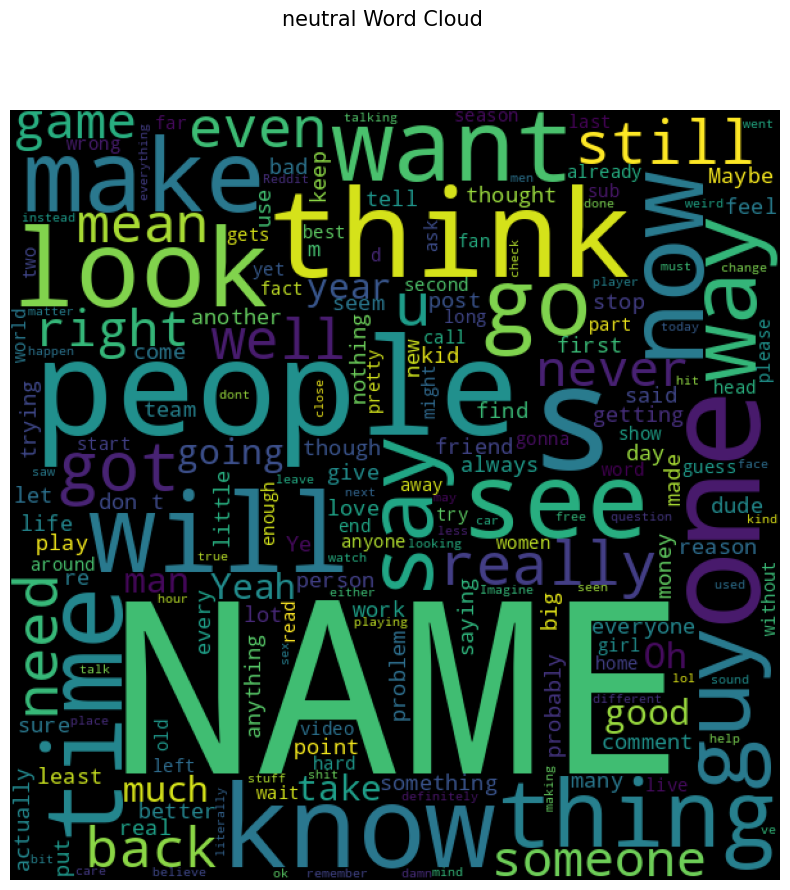

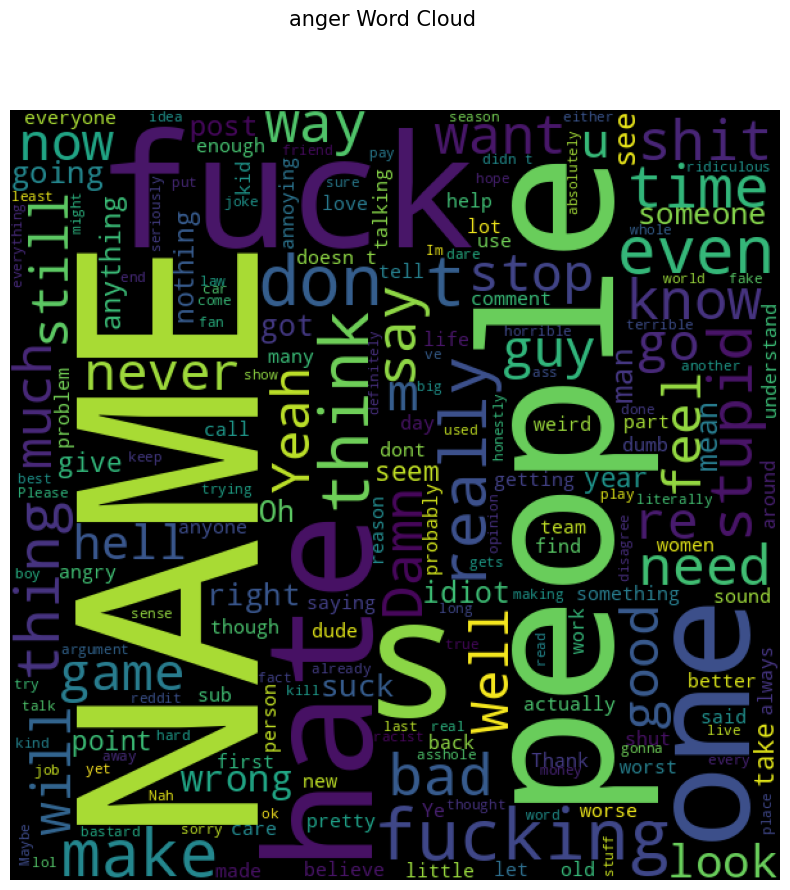

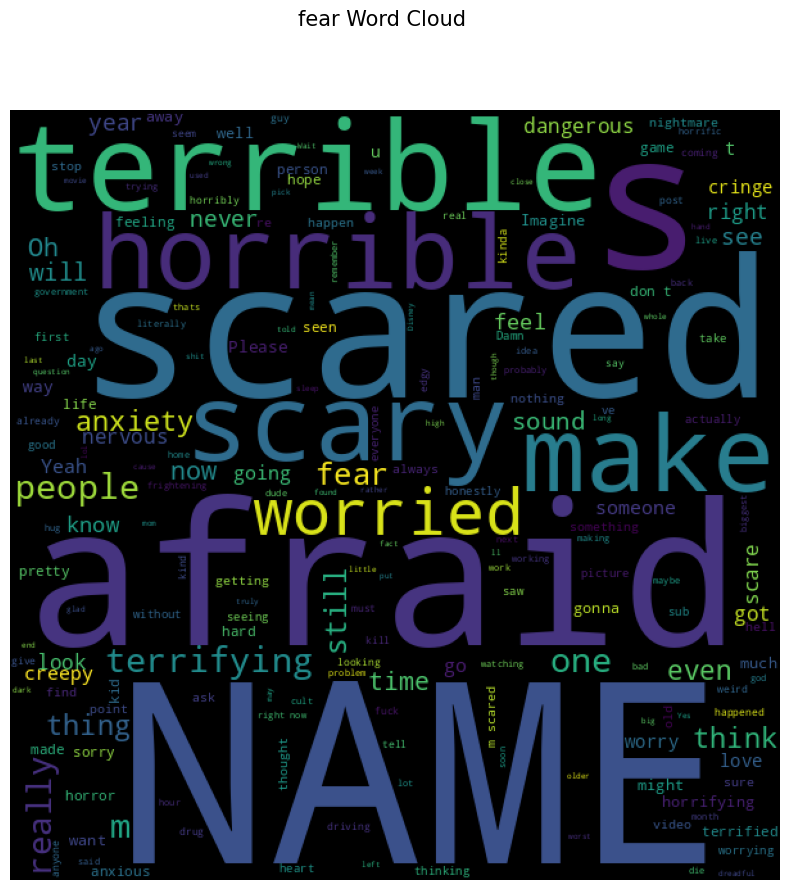

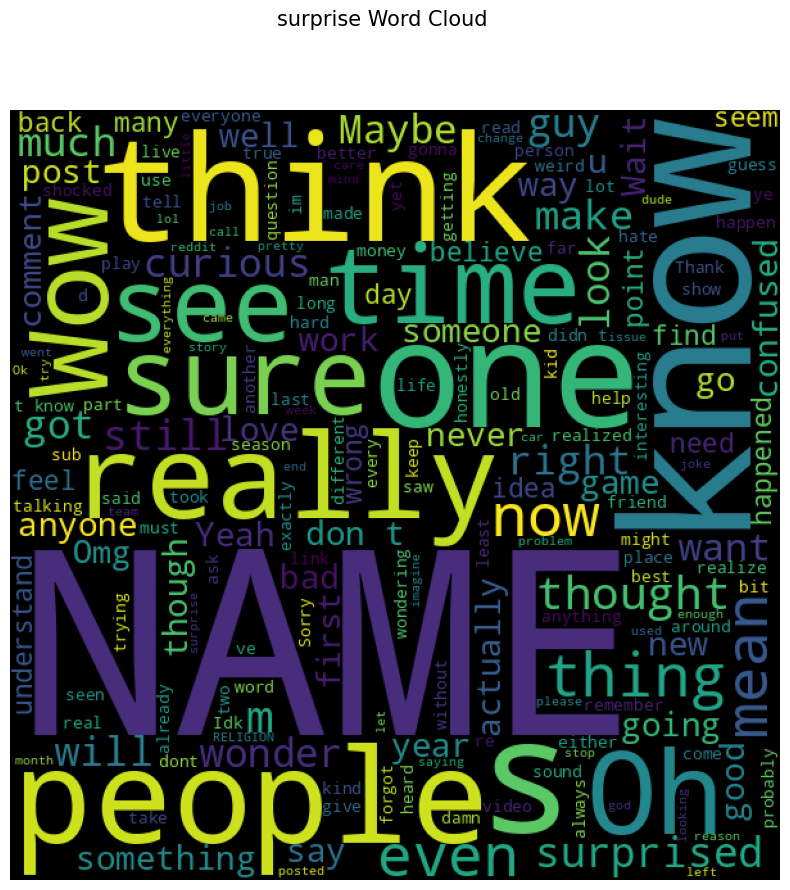

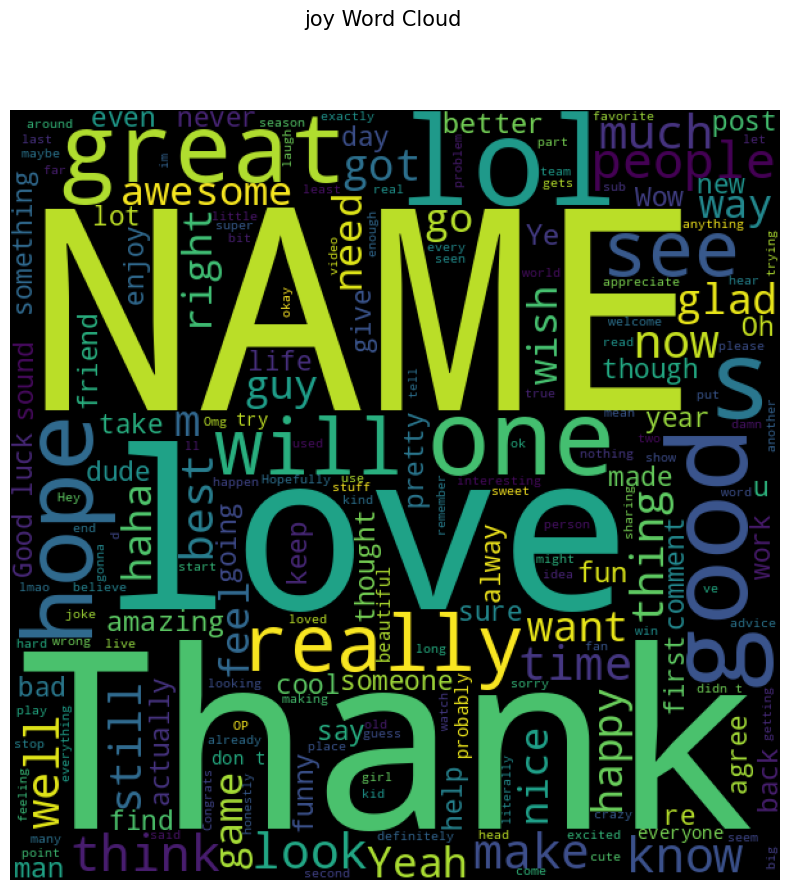

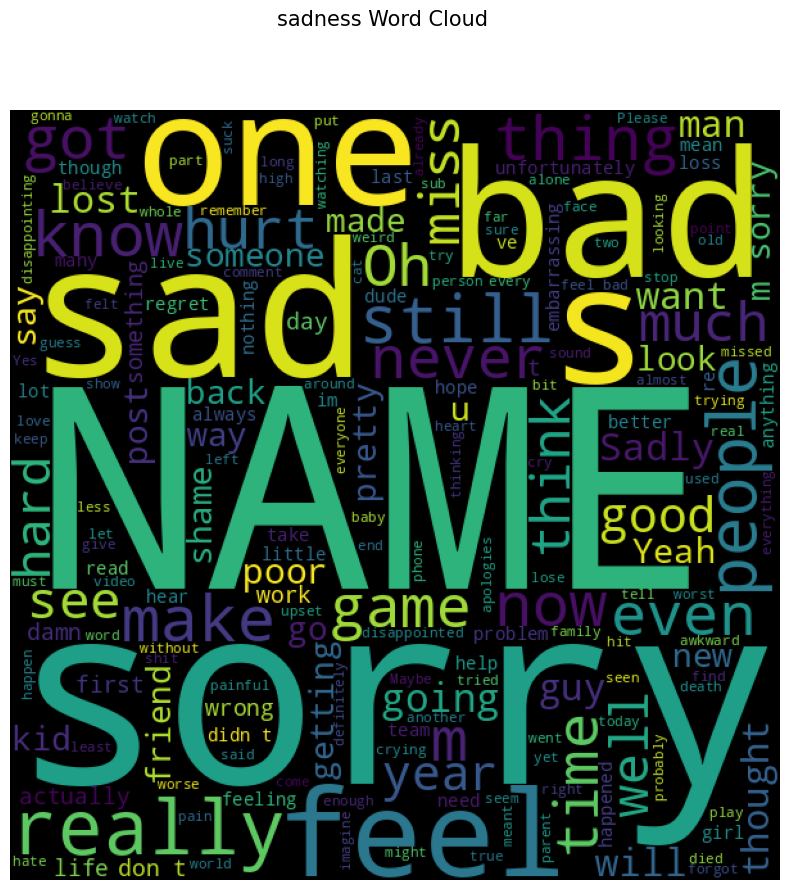

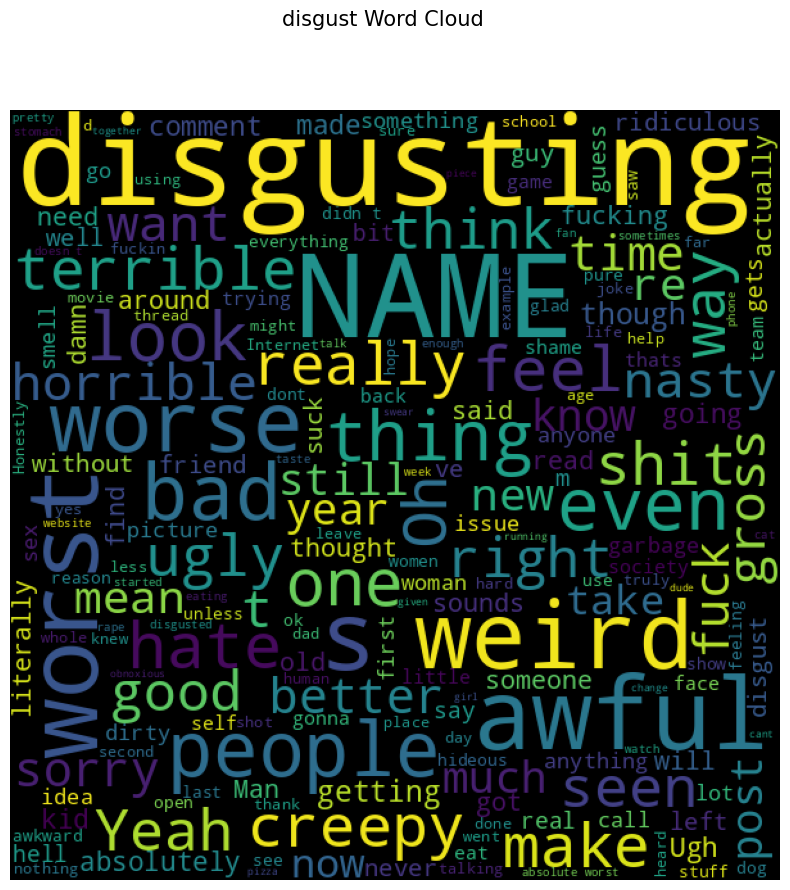

In [16]:
for emotion in emotion_list:
    text = " ".join([sentence for sentence in train_data.loc[train_data["Emotion"] == emotion, "Comment"]])
    wordcloud = WordCloud(width=600, height=600).generate(text)
    word_cloud(wordcloud, emotion)

In [17]:
train_data["Emotion"] = train_data.Emotion.replace({"anger":0, "disgust":1, "fear":2, "joy":3, "sadness":4, "surprise":5, "neutral":6})
test_data["Emotion"] = test_data.Emotion.replace({"anger":0, "disgust":1, "fear":2, "joy":3, "sadness":4, "surprise":5, "neutral":6})
val_data["Emotion"] = val_data.Emotion.replace({"anger":0, "disgust":1, "fear":2, "joy":3, "sadness":4, "surprise":5, "neutral":6})
# Check for null values
print("Train data:", train_data.isnull().sum())

print("Test data:", test_data.isnull().sum())

print("Validation data:", val_data.isnull().sum())

Train data: Comment    0
Emotion    0
dtype: int64
Test data: Comment    0
Emotion    0
dtype: int64
Validation data: Comment    0
Emotion    0
dtype: int64


/tmp/ipykernel_541/2739717648.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data["Emotion"] = train_data.Emotion.replace({"anger":0, "disgust":1, "fear":2, "joy":3, "sadness":4, "surprise":5, "neutral":6})
/tmp/ipykernel_541/2739717648.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data["Emotion"] = test_data.Emotion.replace({"anger":0, "disgust":1, "fear":2, "joy":3, "sadness":4, "surprise":5, "neutral":6})
/tmp/ipykernel_541/2739717648.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and

In [18]:
# Check duplicated values
print("Train data:", train_data.duplicated().sum())

print("Test data:", test_data.duplicated().sum())

print("Validation data:", val_data.duplicated().sum())

Train data: 152
Test data: 6
Validation data: 3


In [19]:
#Removing Duplicated values
index = train_data[train_data.duplicated() == True].index
train_data.drop(index, axis=0, inplace=True)
train_data.reset_index(inplace=True, drop=True)

index = test_data[test_data.duplicated() == True].index
test_data.drop(index, axis=0, inplace=True)
test_data.reset_index(inplace=True, drop=True)

index = val_data[val_data.duplicated() == True].index
val_data.drop(index, axis=0, inplace=True)
val_data.reset_index(inplace=True, drop=True)
#print rows which are duplicated in the text but the same emotion
train_data[train_data["Comment"].duplicated() == True]

Comment  Emotion
6610                                     My man!        3
7925                           What do you mean?        5
8344                         Weird flex but okay        3
8978                                      [NAME]        6
9375                                    Grow up.        0
9481                           Weird flex but ok        1
14012                             You're welcome        6
14104                           This is horrible        2
15809                                    Lol no.        3
20768                                Oh boy yeah        3
20785                                    [NAME]!        6
20866                          Weird flex but ok        0
22881  A surprise to be sure, but a welcome one.        5
23704                I feel personally attacked.        4
24105                          Weird flex but ok        3
24275                               I don't know        5
25076                    That escalated quickly.        5
25353                                    Yes!!!!        3
28886                            Cheers, [NAME]!        6
29036                       He looks like [NAME]        3
31980                     That's how mafia works        5
32741                                 Calm down.        6
37293                              Amen to that!        6
37578                        Underrated comment.        6
39357                               OH MY [NAME]        5
39710                         Not even slightly.        6
39842                             cool story bro        3
40217                      You can't be serious.        6
40670                           What did he say?        5
40894                                 Please no.        0
41542                        This hurts my brain        4

In [20]:
# Removing the duplicate text
index = train_data[train_data["Comment"].duplicated() == True].index
train_data.drop(index, axis=0, inplace = True)
train_data.reset_index(inplace=True, drop=True)

In [21]:
train_data["Length"] = [len(x) for x in train_data["Comment"]]
print(len(stopwords))

# Max length of senetence
max_len = train_data["Length"].max()
print(max_len)

179
703


In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['Comment'])
vocabsize = 18000   #20-12551 #30-15000 43-17555
vocabsize = int(vocabsize * 5 )
print(vocabsize)

90000


In [23]:
def text_cleaning(df, column):
    stemmer = PorterStemmer()
    corpus = []
    
    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    # Split each sentence into a list of words and flatten the list of lists into a single list
    words = [word.lower() for sentence in corpus for word in nltk.word_tokenize(sentence)]

    # Convert the list of words into a set to remove duplicates and find the number of unique words
    unique_words = set(words)
    num_unique_words = len(unique_words)
    word2index = {word: index for index, word in enumerate(unique_words)}
    print(f"Number of unique words: {num_unique_words}")
    one_hot_word = [one_hot(word, vocabsize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding="pre")
    print(pad.shape)
    return pad,word2index

In [24]:
X_train,word2index = text_cleaning(train_data, "Comment")
X_test,word2index = text_cleaning(test_data, "Comment")
X_val,word2index = text_cleaning(val_data, "Comment")

Number of unique words: 17555
(43227, 703)
Number of unique words: 6167
(5421, 703)
Number of unique words: 6237
(5423, 703)


In [ ]:
print(word2index)

{'btw': 0, 'escap': 1, 'especi': 2, 'sketch': 3, 'robot': 4, 'brand': 5, 'fanbas': 6, 'collab': 7, 'prevent': 8, 'artifici': 9, 'shitti': 10, 'salespeopl': 11, 'guid': 12, 'ee': 13, 'christma': 14, 'mao': 15, 'blazer': 16, 'boner': 17, 'spoiler': 18, 'fairi': 19, 'newspap': 20, 'raga': 21, 'kashoggi': 22, 'biker': 23, 'visit': 24, 'ice': 25, 'user': 26, 'dodgi': 27, 'theyr': 28, 'cmc': 29, 'quarter': 30, 'banner': 31, 'masterrac': 32, 'independ': 33, 'activ': 34, 'slam': 35, 'loser': 36, 'labor': 37, 'admiss': 38, 'requir': 39, 'sprout': 40, 'vid': 41, 'cheezboiga': 42, 'harp': 43, 'content': 44, 'rope': 45, 'nationalst': 46, 'flavour': 47, 'afton': 48, 'yike': 49, 'learn': 50, 'sympathi': 51, 'breed': 52, 'northern': 53, 'cheat': 54, 'prompt': 55, 'porn': 56, 'oper': 57, 'appear': 58, 'complet': 59, 'nibba': 60, 'binari': 61, 'unlik': 62, 'dire': 63, 'eso': 64, 'floss': 65, 'gown': 66, 'cloth': 67, 'wax': 68, 'ye': 69, 'mode': 70, 'along': 71, 'eeyor': 72, 'goddam': 73, 'despis': 74, 

In [25]:
y_train = train_data["Emotion"]
y_test = test_data["Emotion"]
y_val = val_data["Emotion"]
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
smote = SMOTE(sampling_strategy='minority')
X_train, y_train = smote.fit_resample(X_train, y_train)
smote = SMOTE(sampling_strategy='minority')
X_test, y_test = smote.fit_resample(X_test, y_test)
y_test.shape

(7386, 7)

In [27]:
smote = SMOTE(sampling_strategy='minority')
X_val, y_val = smote.fit_resample(X_val, y_val)

In [64]:
N_WORDS = vocabsize
DIM_EMBEDDING = 128
MAX_LEN = max_len
def build_model_2(hp):
    dim_embedding = hp.Int("dim_embedding", min_value=64, max_value=128, step=64)
    #activation = hp.Choice("activation", ["relu", "selu","gelu", "swish"])
    conv_filters = hp.Choice("conv_filters", [32,64])
    #dropout_rate = hp.Choice("dropout_rate", [0.2])
    #dropout = hp.Boolean("dropout")
    conv_act = hp.Choice("conv_act", ["relu", "selu", "swish"])
    recc_act = hp.Choice("recc_act", ["selu","swish"])
    is_sep_conv = hp.Boolean("is_sep_conv")
    #is_reccurent = hp.Boolean("is_reccurent")
    number_conv_layers = hp.Choice("number_conv_layers", [1,2])
    #is_conv = hp.Boolean("is_conv")
    number_neurons_rec = hp.Choice("conv_filters", [32,64])
    #optimizer = activation = hp.Choice("optimizer", ["adam", "rmsprop"])
    #lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = SentimentAnalysisModel(n_classes=7, n_words=N_WORDS, dim_embedding=dim_embedding, max_len=MAX_LEN, conv_filters=conv_filters, dropout_rate = 0.2, conv_act=conv_act, recc_act=recc_act, is_conv = True, number_neurons_rec=number_neurons_rec,is_sep_conv=is_sep_conv, is_reccurent=True,number_conv_layers=number_conv_layers)
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy",keras.metrics.F1Score(), keras.metrics.Precision(), keras.metrics.Recall()])
    return model
build_model_2(keras_tuner.HyperParameters())

<SentimentAnalysisModel name=sentiment_analysis_model_1, built=False>

In [66]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model_2,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="my_dir",
    project_name="sem",
)

In [67]:
tuner.search(X_train,y_train, batch_size=100, epochs=10, validation_data=(X_val, y_val))

Trial 10 Complete [00h 05m 55s]
val_accuracy: 0.6602794528007507

Best val_accuracy So Far: 0.6645376086235046
Total elapsed time: 00h 53m 44s


In [69]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=8)
best_model = models[0]
best_model.summary()
models[1].summary()
models[2].summary()
models[3].summary()
models[4].summary()
models[5].summary()
models[6].summary()

Model: "sentiment_analysis_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 703, 64)        │     5,760,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 703, 64)        │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 703, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 351, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,789,831 (22.09 MB)

 Trainable params: 5,789,703 (22.09 MB)

 Non-trainable params: 128 (512.00 B)

Model: "sentiment_analysis_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 703, 128)       │    11,520,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 703, 32)        │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 703, 16)        │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 703, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 351, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 32)             │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,529,751 (43.98 MB)

 Trainable params: 11,529,719 (43.98 MB)

 Non-trainable params: 32 (128.00 B)

Model: "sentiment_analysis_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 703, 128)       │    11,520,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 703, 32)        │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 703, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 351, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,530,823 (43.99 MB)

 Trainable params: 11,530,759 (43.99 MB)

 Non-trainable params: 64 (256.00 B)

Model: "sentiment_analysis_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 703, 64)        │     5,760,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 703, 64)        │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 703, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 351, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,789,831 (22.09 MB)

 Trainable params: 5,789,703 (22.09 MB)

 Non-trainable params: 128 (512.00 B)

Model: "sentiment_analysis_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 703, 64)        │     5,760,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 703, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 703, 16)        │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 703, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 351, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 32)             │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,767,703 (22.00 MB)

 Trainable params: 5,767,671 (22.00 MB)

 Non-trainable params: 32 (128.00 B)

Model: "sentiment_analysis_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 703, 128)       │    11,520,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 703, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 703, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 351, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,553,927 (44.07 MB)

 Trainable params: 11,553,799 (44.07 MB)

 Non-trainable params: 128 (512.00 B)

Model: "sentiment_analysis_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 703, 64)        │     5,760,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 703, 64)        │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 703, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 351, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,789,831 (22.09 MB)

 Trainable params: 5,789,703 (22.09 MB)

 Non-trainable params: 128 (512.00 B)

In [70]:
tuner.results_summary()

Results summary
Results in my_dir/sem
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 02 summary
Hyperparameters:
dim_embedding: 64
conv_filters: 64
conv_act: selu
recc_act: swish
is_sep_conv: True
number_conv_layers: 1
Score: 0.6645376086235046

Trial 01 summary
Hyperparameters:
dim_embedding: 128
conv_filters: 32
conv_act: selu
recc_act: swish
is_sep_conv: True
number_conv_layers: 2
Score: 0.6636061072349548

Trial 08 summary
Hyperparameters:
dim_embedding: 128
conv_filters: 32
conv_act: swish
recc_act: swish
is_sep_conv: True
number_conv_layers: 1
Score: 0.663206934928894

Trial 04 summary
Hyperparameters:
dim_embedding: 64
conv_filters: 64
conv_act: swish
recc_act: selu
is_sep_conv: False
number_conv_layers: 1
Score: 0.6618762612342834

Trial 00 summary
Hyperparameters:
dim_embedding: 64
conv_filters: 32
conv_act: swish
recc_act: selu
is_sep_conv: False
number_conv_layers: 2
Score: 0.6604124903678894

Trial 09 summary
Hyperparameters:
dim_embedding: 12

In [71]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config
class SentimentAnalysisModel(Sequential):
    def __init__(self, n_classes, n_words, dim_embedding, max_len, conv_filters=64, dropout_rate=0.2, conv_act='relu', recc_act = 'relu', number_conv_layers=2, is_sep_conv=False, is_reccurent = True, is_conv = True, type_rec='gru', number_neurons_rec=64, number_dense=1):
        super(SentimentAnalysisModel, self).__init__()
        self.add(layers.Embedding(n_words, dim_embedding, input_length=max_len+2))
        self.add(TransformerEncoder(dim_embedding, 64, 2))
        if is_conv:
            for i in range(number_conv_layers):
                if not is_sep_conv:
                    self.add(layers.Conv1D(conv_filters,activation=conv_act, kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
                else: 
                    self.add(layers.Conv1D(conv_filters,activation=conv_act, kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
                conv_filters = conv_filters//2
            #self.add(layers.Conv1D(conv_filters//2,activation=conv_act, kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
        self.add(layers.BatchNormalization())
        if is_reccurent:
            self.add(keras.layers.MaxPooling1D(2))
        else:
            self.add(GlobalMaxPool1D())
        if is_reccurent:
            if type_rec=='gru':
                self.add(layers.GRU(number_neurons_rec, activation=recc_act))
            else:
                self.add(layers.LSTM(number_neurons_rec, activation=recc_act))
        self.add(layers.Dropout(dropout_rate))
        if n_classes==2:
            self.add(layers.Dense(1, activation='sigmoid'))
        else:
            self.add(layers.Flatten())
            self.add(layers.Dense(n_classes, activation='softmax'))

    def call(self, inputs):
        return super(SentimentAnalysisModel, self).call(inputs)

In [95]:
N_WORDS = vocabsize
DIM_EMBEDDING = 128
MAX_LEN = max_len
def build_model_2(hp):
    dim_embedding = hp.Int("dim_embedding", min_value=64, max_value=128, step=64)
    #activation = hp.Choice("activation", ["relu", "selu","gelu", "swish"])
    conv_filters = hp.Choice("conv_filters", [32,64])
    #dropout_rate = hp.Choice("dropout_rate", [0.2])
    #dropout = hp.Boolean("dropout")
    conv_act = hp.Choice("conv_act", ["relu", "selu", "swish"])
    recc_act = hp.Choice("recc_act", ["selu","swish"])
    is_sep_conv = hp.Boolean("is_sep_conv")
    #is_reccurent = hp.Boolean("is_reccurent")
    number_conv_layers = hp.Choice("number_conv_layers", [1,2])
    #is_conv = hp.Boolean("is_conv")
    number_neurons_rec = hp.Choice("conv_filters", [32,64])
    #optimizer = activation = hp.Choice("optimizer", ["adam", "rmsprop"])
    #lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = SentimentAnalysisModel(n_classes=7, n_words=N_WORDS, dim_embedding=dim_embedding, max_len=MAX_LEN, conv_filters=conv_filters, dropout_rate = 0.2, conv_act=conv_act, recc_act=recc_act, is_conv = True, number_neurons_rec=number_neurons_rec,is_sep_conv=is_sep_conv, is_reccurent=True,number_conv_layers=number_conv_layers)
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy",keras.metrics.F1Score(), keras.metrics.Precision(), keras.metrics.Recall()])
    return model
build_model_2(keras_tuner.HyperParameters())

<SentimentAnalysisModel name=sentiment_analysis_model_1, built=False>

In [96]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model_2,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="my_dir",
    project_name="sem",
)

In [75]:
models = tuner.get_best_models(num_models=8)
best_model = models[0]
best_model.summary()
models[1].summary()
models[2].summary()
models[3].summary()
models[4].summary()
models[5].summary()
models[6].summary()

Model: "sentiment_analysis_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 703, 128)       │    11,520,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 703, 128)       │       149,056 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 703, 32)        │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 703, 16)        │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 703, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 351, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 32)             │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,678,807 (44.55 MB)

 Trainable params: 11,678,775 (44.55 MB)

 Non-trainable params: 32 (128.00 B)

Model: "sentiment_analysis_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 703, 128)       │    11,520,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 703, 128)       │       149,056 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 703, 32)        │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 703, 16)        │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 703, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 351, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 32)             │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,678,807 (44.55 MB)

 Trainable params: 11,678,775 (44.55 MB)

 Non-trainable params: 32 (128.00 B)

Model: "sentiment_analysis_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 703, 128)       │    11,520,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 703, 128)       │       149,056 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 703, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 703, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 351, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,702,983 (44.64 MB)

 Trainable params: 11,702,855 (44.64 MB)

 Non-trainable params: 128 (512.00 B)

Model: "sentiment_analysis_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 703, 128)       │    11,520,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 703, 128)       │       149,056 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 703, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 703, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 703, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 351, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,698,791 (44.63 MB)

 Trainable params: 11,698,727 (44.63 MB)

 Non-trainable params: 64 (256.00 B)

Model: "sentiment_analysis_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 703, 64)        │     5,760,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 703, 64)        │        41,792 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 703, 64)        │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 703, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 351, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831,623 (22.25 MB)

 Trainable params: 5,831,495 (22.25 MB)

 Non-trainable params: 128 (512.00 B)

Model: "sentiment_analysis_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 703, 64)        │     5,760,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 703, 64)        │        41,792 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 703, 64)        │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 703, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 351, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831,623 (22.25 MB)

 Trainable params: 5,831,495 (22.25 MB)

 Non-trainable params: 128 (512.00 B)

Model: "sentiment_analysis_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 703, 64)        │     5,760,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 703, 64)        │        41,792 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 703, 64)        │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 703, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 703, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 351, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,827,431 (22.23 MB)

 Trainable params: 5,827,367 (22.23 MB)

 Non-trainable params: 64 (256.00 B)

In [76]:
tuner.results_summary()

Results summary
Results in my_dir/sem
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
dim_embedding: 128
conv_filters: 32
conv_act: relu
recc_act: swish
is_sep_conv: True
number_conv_layers: 2
Score: 0.675981342792511

Trial 03 summary
Hyperparameters:
dim_embedding: 128
conv_filters: 32
conv_act: swish
recc_act: swish
is_sep_conv: False
number_conv_layers: 2
Score: 0.6730539202690125

Trial 02 summary
Hyperparameters:
dim_embedding: 128
conv_filters: 64
conv_act: swish
recc_act: swish
is_sep_conv: True
number_conv_layers: 1
Score: 0.6703925728797913

Trial 04 summary
Hyperparameters:
dim_embedding: 128
conv_filters: 64
conv_act: swish
recc_act: selu
is_sep_conv: True
number_conv_layers: 2
Score: 0.6677312254905701

Trial 08 summary
Hyperparameters:
dim_embedding: 64
conv_filters: 64
conv_act: swish
recc_act: selu
is_sep_conv: False
number_conv_layers: 1
Score: 0.6665335893630981

Trial 06 summary
Hyperparameters:
dim_embedding:

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config
N_WORDS = vocabsize
DIM_EMBEDDING = 128
MAX_LEN = max_len
model = Sequential()
model.add(layers.Embedding(input_dim=vocabsize, output_dim=600, input_length=max_len))
model.add(TransformerEncoder(600,512, 2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(512, activation="selu", kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
model.add(layers.BatchNormalization())
#model.add(layers.Bidirectional(LSTM(512, return_sequences=True)))
#model.add(Dropout(0.2))
model.add(layers.Bidirectional(layers.LSTM(256)))
model.add(layers.Dropout(0.2))
#model.add(layers.Dense(60, activation="sigmoid"))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(7, activation="softmax"))
#model.add(layers.Embedding(N_WORDS, DIM_EMBEDDING, input_length=MAX_LEN))
#model.add(TransformerEncoder(DIM_EMBEDDING, 128, 2))
#model.add(layers.Conv1D(64, activation="relu", kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
#model.add(layers.Conv1D(128, activation="relu", kernel_size=1,kernel_initializer = "glorot_uniform",padding='same'))
#model.add(layers.BatchNormalization())
#model.add(layers.MaxPooling1D(10))
#model.add(layers.Dropout(0.4))
#model.add(layers.GRU(32, activation="swish"))
#model.add(layers.Dropout(0.4))
#model.add(layers.Flatten())
#model.add(layers.Dense(7, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy",keras.metrics.F1Score(), keras.metrics.Precision(), keras.metrics.Recall()])
model.fit(X_train,y_train, batch_size=200, epochs=10, validation_data = (X_val, y_val))

Epoch 1/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 723s 2s/step - accuracy: 0.4197 - f1_score: 0.2256 - loss: 1.4452 - precision: 0.6525 - recall: 0.1930 - val_accuracy: 0.3534 - val_f1_score: 0.2733 - val_loss: 1.9984 - val_precision: 0.8232 - val_recall: 0.2064
Epoch 2/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 709s 2s/step - accuracy: 0.7194 - f1_score: 0.5643 - loss: 0.7831 - precision: 0.8113 - recall: 0.6207 - val_accuracy: 0.5418 - val_f1_score: 0.3088 - val_loss: 1.2816 - val_precision: 0.6495 - val_recall: 0.4327
Epoch 3/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 713s 2s/step - accuracy: 0.7624 - f1_score: 0.6489 - loss: 0.6596 - precision: 0.8361 - recall: 0.6885 - val_accuracy: 0.2882 - val_f1_score: 0.0640 - val_loss: 3.7953 - val_precision: 0.2896 - val_recall: 0.2882
Epoch 4/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 714s 2s/step - accuracy: 0.7997 - f1_score: 0.7022 - loss: 0.5767 - precision: 0.8567 - recall: 0.7389 - val_accuracy: 0.2951 - val_f1_score: 0.0755 - val_loss: 3.4729 - val_precision: 0.2990 - val_rec

In [35]:
model.export("emotions4")
model.save("emotions4.h5")
model.save('emotions4.keras')
import tensorflow as tf
tf.saved_model.save(model, "emot4" )


Saved artifact at 'emotions4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 703), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  136000079554944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136000119472192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136000121015632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136000119487504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136000121023024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136000121021264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136000121013872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136000121021792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136000121022496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136000121025488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136000121020384: TensorSpec(s

In [36]:
model.evaluate(X_test, y_test)

231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 122ms/step - accuracy: 0.3797 - f1_score: 0.3429 - loss: 2.3861 - precision: 0.4110 - recall: 0.3330


[1.8702749013900757,
 0.5104251503944397,
 <tf.Tensor: shape=(7,), dtype=float32, numpy=
 array([0.2919807 , 0.91796964, 0.30534348, 0.4277715 , 0.23486237,
        0.29120192, 0.4061995 ], dtype=float32)>,
 0.5580393075942993,
 0.4731925129890442]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [187]:
import tensorflow
import keras
from keras import layers
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config
#model2 = tensorflow.saved_model.load("/kaggle/working/emot")
loaded_model = keras.saving.load_model("/kaggle/working/emotions2.keras", custom_objects = {'TransformerEncoder':TransformerEncoder})


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'transformer_encoder_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 31 variables whereas the saved optimizer has 60 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [15]:
import tensorflow
print(tensorflow.__version__)
print(keras.__version__)

2.15.0
3.3.3


In [196]:
import json
import re 
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
stemmer = PorterStemmer()
from tensorflow.keras.preprocessing.text import Tokenizer
#tokenizer = Tokenizer()
stopwords = stopwords.words("english")
vocabsize = 18000   #20-12551 #30-15000 43-17555
vocabsize = int(vocabsize * 5 )
max_len = 703
test = []
corpus = []
sentence = 'i am afraid its so scary '
text = re.sub("[^a-zA-Z]", " ", sentence)
text = text.lower()
text = text.split()
text = [stemmer.stem(word) for word in text if word not in stopwords]
text = " ".join(text)
for word in word_tokenize(text):
    if word in word2index:
         test.append(word2index[word])

test=pad_sequences([test],maxlen=max_len)
#print(y_test[1])
#'LOL'
#tokenizer = Tokenizer(num_words=vocabsize)
#tokenizer.fit_on_texts([sentence])  # Fit the tokenizer on the sentence

# Tokenize the sentence using the fitted tokenizer
#tokenized_sentence = tokenizer.texts_to_sequences([sentence])
#print(tokenized_sentence)
# Pad or truncate the sequence to match the input shape of your model
#max_sequence_length = 100  # define your maximum sequence length
#padded_sequence = pad_sequences(tokenized_sentence, maxlen=max_len, padding='post')

#test_data = text_cleaning_test_2(test,vocabsize, max_len,stopwords)
#print(test_data)

predictions = loaded_model.predict(test)[0]
print('predictions',predictions)
predicted_classes = np.argmax(predictions)

print(predicted_classes)

print()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
predictions [1.6066254e-03 6.7635489e-01 2.7857616e-06 1.4599277e-01 3.4547906e-04
 3.5864919e-02 1.3983253e-01]
0



In [120]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize text data
sample_text = "I'm feeling excited about the project!"
#sample_label = "excitement"  # Example label for the sample text

# Tokenize the sample text sentence using the same tokenizer used during training
#tokenizer = Tokenizer()
#tokenizer.fit_on_texts(goemotions_data['text'].values)  # Assuming 'goemotions_data' is the dataset used for training

sample_sequence = tokenizer.texts_to_sequences([sample_text])

# Pad the sequence to a fixed length
max_sequence_length = 703  # Use the same sequence length as during training
padded_sequence = pad_sequences(sample_sequence, maxlen=max_sequence_length, padding='post')

# If you have the corresponding label, prepare it for prediction
# For example, using one-hot encoding for the label
#num_classes = len(goemotions_data['labels'].unique())
#sample_label_one_hot = tf.one_hot([sample_label], num_classes)

# The prepared input 'padded_sequence' and label 'sample_label_one_hot' can be used for model prediction

print("Padded Sequence:")
print(padded_sequence)
print("\nSample Label in One-Hot Encoding:")
print(sample_label_one_hot)

Padded Sequence:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0

NameError: name 'sample_label_one_hot' is not defined

In [58]:
model.save('model_name.model')

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=model_name.model.

In [55]:
print(keras.__version__)
model.save("model.keras")
loaded_model = tf.keras.saving.load_model("model.keras")

3.3.3


AttributeError: module 'keras._tf_keras.keras' has no attribute 'saving'

In [75]:
!zip -r emot2.zip /kaggle/working/emot2

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/emot2/ (stored 0%)
  adding: kaggle/working/emot2/variables/ (stored 0%)
  adding: kaggle/working/emot2/variables/variables.index (deflated 63%)
  adding: kaggle/working/emot2/variables/variables.data-00000-of-00001 (deflated 29%)
  adding: kaggle/working/emot2/assets/ (stored 0%)
  adding: kaggle/working/emot2/fingerprint.pb (stored 0%)
  adding: kaggle/working/emot2/saved_model.pb (deflated 89%)


In [ ]:
def text_cleaning_test(sentence):
    stemmer = PorterStemmer()
    corpus = []
    
    for text in sentence:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    # Split each sentence into a list of words and flatten the list of lists into a single list
    words = [word.lower() for sentence in corpus for word in nltk.word_tokenize(sentence)]

    # Convert the list of words into a set to remove duplicates and find the number of unique words
    unique_words = set(words)
    num_unique_words = len(unique_words)
    one_hot_word = [one_hot(word, vocabsize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding="pre")
    return pad
test = 'good like'

predictions = best_model.predict(text_cleaning_test(test))
index = predictions.argmax(axis=-1)
print(index)
print()